In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [2]:
from load_data import load_data,class_breakdown

In [3]:
data_name ="HAR"
trainx, testx,trainy,testy,batch_size = load_data(data_name =data_name)

Load data HAR
batch size:16
train data (7352, 128, 9),(7352, 1)
test data (2947, 128, 9),(2947, 1)


In [4]:
class_breakdown(trainy)
class_breakdown(testy)

Class=1, total=1226, percentage=16.676
Class=2, total=1073, percentage=14.595
Class=3, total=986, percentage=13.411
Class=4, total=1286, percentage=17.492
Class=5, total=1374, percentage=18.689
Class=6, total=1407, percentage=19.138
Class=1, total=496, percentage=16.831
Class=2, total=471, percentage=15.982
Class=3, total=420, percentage=14.252
Class=4, total=491, percentage=16.661
Class=5, total=532, percentage=18.052
Class=6, total=537, percentage=18.222


In [5]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (7352, 6)
y test shape: (2947, 6)


## 데이터 정규화

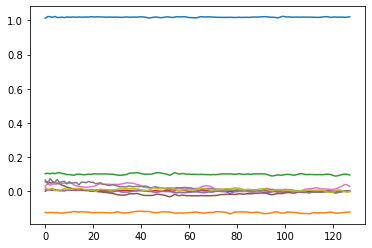

In [6]:
plt.plot(trainx[0])

In [7]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
trainx =TimeSeriesScalerMeanVariance().fit_transform(trainx)
testx =TimeSeriesScalerMeanVariance().fit_transform(testx)

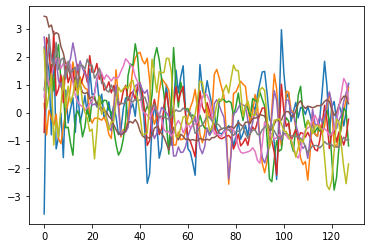

In [8]:
plt.plot(trainx[0])

In [9]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train

validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]

testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]

print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(7352, 1, 128, 9)
trainY shape:(7352, 6)
validX shape:(1473, 1, 128, 9)
validY shape:(1473, 6)
testX shape:(1474, 1, 128, 9)
testY shape:(1474, 6)


In [10]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 128
input_channel 9


# 2. Training condition 정의

In [11]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 500


std= 0.01
l_rate = 1e-4

In [12]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [13]:
from FCN import CNN_MC_dropout, CNN_MC_dropout_turnoff

/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3

In [14]:
from numpy import unique
nb_classes =trainY.shape[1]
print (nb_classes)

6


<font color='red'> turn off 구조는 마지막 convolution layer activation output 에 weight를 elementwise multiply 구조.
train, test시에는 이 weight를 모두 1로 고정하며,
prdiction 시에는 convolution layer activation output에서 상위 T%를 turn off 시키며 accuracy의 변화가 A 이상인 경우를
threshold로 정하기 위해 이러한 모델 구조가 설정되었습니다.</font>

In [15]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()
    
MC_dropout_model =CNN_MC_dropout_turnoff(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

In [16]:
print (MC_dropout_model.input)
print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3]')
print (MC_dropout_model.conv3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)
print (MC_dropout_model.threshold_relu3)

print ('[layer4]')
print (MC_dropout_model.GAP)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 128, 9), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer1/dropout/mul:0", shape=(?, 1, 128, 128), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 128, 256), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 128, 256), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 128, 256), dtype=float32)
Tensor("layer2/dropout/mul:0", shape=(?, 1, 128, 256), dtype=float32)
[layer3]
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer3/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer3/Relu:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer3/Mul:0", shape=(?, 1, 128, 128), dtype=float

# 4. Training

In [17]:
import time
import os
import numpy as np

In [18]:
save_path = './model/'+data_name
model_name = data_name+"_CNN_MCdropout_threshold_standardized_"+str(l_rate)+'_'+str(batch_size)
print (model_name)

HAR_CNN_MCdropout_threshold_standardized_0.0001_16


In [19]:
from training import get_batch

In [20]:
keep_prob =1.0

In [21]:
for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, nb_classes = nb_classes, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,is_dropout=False)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, nb_classes = nb_classes, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,is_dropout=False)
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        print("  validation acc:\t{:.3f}".format(v_acc[epoch]))


INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/1.ckpt
  training loss:	1.784581
  training acc:	0.833
  validation loss:	1.779683
  validation acc:	0.833
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/2.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/2.ckpt
  training loss:	1.760992
  training acc:	0.833
  validation loss:	1.761436
  validation acc:	0.833
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/3.ckpt
  training loss:	1.716218
  training acc:	0.833
  validation loss:	1.725657
  validation acc:	0

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/25.ckpt
  training loss:	0.713507
  training acc:	0.918
  validation loss:	1.248224
  validation acc:	0.872
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/26.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/26.ckpt
  training loss:	0.702776
  training acc:	0.919
  validation loss:	1.244017
  validation acc:	0.872
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/27.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/27.ckpt
  training loss:	0.692788
  training acc:	0.920
  validation loss:	1.240052
  validation acc:	0.872
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/28.ckpt is not in all_model_checkpoint_paths. Manually 

INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/50.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/50.ckpt
  training loss:	0.552177
  training acc:	0.931
  validation loss:	1.111972
  validation acc:	0.881
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/51.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/51.ckpt
  training loss:	0.548073
  training acc:	0.931
  validation loss:	1.106232
  validation acc:	0.881
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/52.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/52.ckpt
  training loss:	0.544081
  training acc:	0.932
  validation loss:	1.100492
  validation 

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/74.ckpt
  training loss:	0.478996
  training acc:	0.937
  validation loss:	1.004698
  validation acc:	0.891
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/75.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/75.ckpt
  training loss:	0.476829
  training acc:	0.937
  validation loss:	1.001517
  validation acc:	0.891
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/76.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/76.ckpt
  training loss:	0.474726
  training acc:	0.937
  validation loss:	0.998632
  validation acc:	0.891
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/77.ckpt is not in all_model_checkpoint_paths. Manually 

INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/99.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/99.ckpt
  training loss:	0.437510
  training acc:	0.941
  validation loss:	0.949686
  validation acc:	0.897
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/100.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/100.ckpt
  training loss:	0.436270
  training acc:	0.941
  validation loss:	0.948245
  validation acc:	0.897
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/101.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/101.ckpt
  training loss:	0.435060
  training acc:	0.942
  validation loss:	0.946792
  validat

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/123.ckpt
  training loss:	0.413215
  training acc:	0.943
  validation loss:	0.923542
  validation acc:	0.901
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/124.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/124.ckpt
  training loss:	0.412397
  training acc:	0.944
  validation loss:	0.922722
  validation acc:	0.900
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/125.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/125.ckpt
  training loss:	0.411590
  training acc:	0.944
  validation loss:	0.921870
  validation acc:	0.901
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/126.ckpt is not in all_model_checkpoint_paths. Man

  training loss:	0.396262
  training acc:	0.946
  validation loss:	0.909385
  validation acc:	0.903
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/148.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/148.ckpt
  training loss:	0.395655
  training acc:	0.946
  validation loss:	0.908931
  validation acc:	0.903
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/149.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/149.ckpt
  training loss:	0.395056
  training acc:	0.946
  validation loss:	0.908503
  validation acc:	0.903
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/150.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.

INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/172.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/172.ckpt
  training loss:	0.382684
  training acc:	0.946
  validation loss:	0.900498
  validation acc:	0.905
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/173.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/173.ckpt
  training loss:	0.382199
  training acc:	0.946
  validation loss:	0.900354
  validation acc:	0.905
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/174.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/174.ckpt
  training loss:	0.381718
  training acc:	0.947
  validation loss:	0.900179
  valid

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/196.ckpt
  training loss:	0.371966
  training acc:	0.948
  validation loss:	0.896263
  validation acc:	0.906
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/197.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/197.ckpt
  training loss:	0.371552
  training acc:	0.948
  validation loss:	0.896044
  validation acc:	0.906
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/198.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/198.ckpt
  training loss:	0.371143
  training acc:	0.948
  validation loss:	0.895781
  validation acc:	0.906
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/199.ckpt is not in all_model_checkpoint_paths. Man

  training loss:	0.362554
  training acc:	0.950
  validation loss:	0.891384
  validation acc:	0.906
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/221.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/221.ckpt
  training loss:	0.362180
  training acc:	0.950
  validation loss:	0.891251
  validation acc:	0.906
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/222.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/222.ckpt
  training loss:	0.361807
  training acc:	0.950
  validation loss:	0.891139
  validation acc:	0.906
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/223.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.

INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/245.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/245.ckpt
  training loss:	0.353638
  training acc:	0.951
  validation loss:	0.889654
  validation acc:	0.908
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/246.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/246.ckpt
  training loss:	0.353304
  training acc:	0.951
  validation loss:	0.889727
  validation acc:	0.908
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/247.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/247.ckpt
  training loss:	0.352970
  training acc:	0.951
  validation loss:	0.889886
  valid

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/269.ckpt
  training loss:	0.345950
  training acc:	0.952
  validation loss:	0.890049
  validation acc:	0.909
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/270.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/270.ckpt
  training loss:	0.345647
  training acc:	0.952
  validation loss:	0.890087
  validation acc:	0.909
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/271.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/271.ckpt
  training loss:	0.345344
  training acc:	0.952
  validation loss:	0.890032
  validation acc:	0.909
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/272.ckpt is not in all_model_checkpoint_paths. Man

  training loss:	0.338912
  training acc:	0.953
  validation loss:	0.889752
  validation acc:	0.909
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/294.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/294.ckpt
  training loss:	0.338630
  training acc:	0.953
  validation loss:	0.889777
  validation acc:	0.909
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/295.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/295.ckpt
  training loss:	0.338351
  training acc:	0.953
  validation loss:	0.889787
  validation acc:	0.909
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/296.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.

INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/318.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/318.ckpt
  training loss:	0.332080
  training acc:	0.954
  validation loss:	0.891772
  validation acc:	0.909
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/319.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/319.ckpt
  training loss:	0.331815
  training acc:	0.954
  validation loss:	0.891898
  validation acc:	0.909
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/320.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/320.ckpt
  training loss:	0.331549
  training acc:	0.954
  validation loss:	0.891997
  valid

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/342.ckpt
  training loss:	0.325845
  training acc:	0.955
  validation loss:	0.893490
  validation acc:	0.910
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/343.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/343.ckpt
  training loss:	0.325591
  training acc:	0.955
  validation loss:	0.893709
  validation acc:	0.910
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/344.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/344.ckpt
  training loss:	0.325339
  training acc:	0.955
  validation loss:	0.893935
  validation acc:	0.910
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/345.ckpt is not in all_model_checkpoint_paths. Man

  training loss:	0.319917
  training acc:	0.955
  validation loss:	0.896525
  validation acc:	0.910
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/367.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/367.ckpt
  training loss:	0.319677
  training acc:	0.955
  validation loss:	0.896550
  validation acc:	0.910
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/368.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/368.ckpt
  training loss:	0.319435
  training acc:	0.955
  validation loss:	0.896746
  validation acc:	0.910
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/369.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.

INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/391.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/391.ckpt
  training loss:	0.314009
  training acc:	0.956
  validation loss:	0.900046
  validation acc:	0.911
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/392.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/392.ckpt
  training loss:	0.313778
  training acc:	0.956
  validation loss:	0.900169
  validation acc:	0.911
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/393.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/393.ckpt
  training loss:	0.313551
  training acc:	0.956
  validation loss:	0.900372
  valid

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/415.ckpt
  training loss:	0.308556
  training acc:	0.957
  validation loss:	0.903248
  validation acc:	0.912
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/416.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/416.ckpt
  training loss:	0.308331
  training acc:	0.958
  validation loss:	0.903531
  validation acc:	0.912
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/417.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/417.ckpt
  training loss:	0.308107
  training acc:	0.957
  validation loss:	0.903542
  validation acc:	0.912
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/418.ckpt is not in all_model_checkpoint_paths. Man

  training loss:	0.303227
  training acc:	0.958
  validation loss:	0.905296
  validation acc:	0.912
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/440.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/440.ckpt
  training loss:	0.303010
  training acc:	0.958
  validation loss:	0.905497
  validation acc:	0.912
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/441.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/441.ckpt
  training loss:	0.302792
  training acc:	0.958
  validation loss:	0.905665
  validation acc:	0.912
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/442.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.

INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/464.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/464.ckpt
  training loss:	0.297863
  training acc:	0.959
  validation loss:	0.907593
  validation acc:	0.912
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/465.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/465.ckpt
  training loss:	0.297651
  training acc:	0.959
  validation loss:	0.907765
  validation acc:	0.912
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/466.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/466.ckpt
  training loss:	0.297439
  training acc:	0.959
  validation loss:	0.907942
  valid

Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/488.ckpt
  training loss:	0.292841
  training acc:	0.960
  validation loss:	0.909575
  validation acc:	0.913
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/489.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/489.ckpt
  training loss:	0.292635
  training acc:	0.960
  validation loss:	0.909738
  validation acc:	0.913
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/490.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/490.ckpt
  training loss:	0.292425
  training acc:	0.960
  validation loss:	0.909837
  validation acc:	0.913
INFO:tensorflow:./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/491.ckpt is not in all_model_checkpoint_paths. Man

In [22]:
train_history.to_csv(os.path.join(save_path,model_name,  "history_train.csv"))
valid_history.to_csv(os.path.join(save_path,model_name,  "history_valid.csv"))

# 5.check the result

### with loss and accuracy graph

In [23]:
from visualization import plot_train_history

In [24]:
train_history = pd.read_csv(os.path.join(save_path,model_name,"history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path,model_name,"history_valid.csv"),index_col=0)

save ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/loss_graph.png
save ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/acc_graph.png


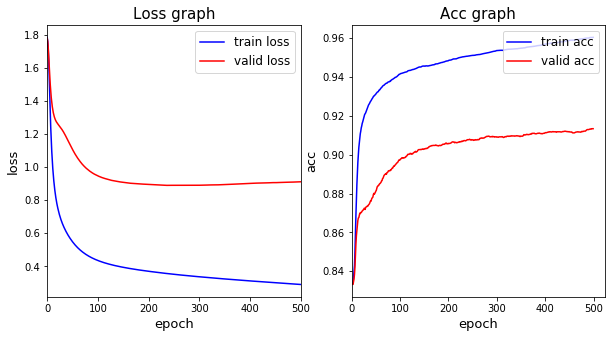

In [25]:
plot_train_history(train_df = train_history,
                   valid_df = valid_history,
                   save_path = os.path.join(save_path,model_name))

In [26]:
bestepoch = int(np.argmin(valid_history['loss'].values))

In [27]:
error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))

error: 0.8895161337541535


In [28]:
bestepoch=bestepoch
MC_dropout_model.load(os.path.join(save_path,model_name,str(bestepoch)+'.ckpt'))

INFO:tensorflow:Restoring parameters from ./model/HAR/HAR_CNN_MCdropout_threshold_standardized_0.0001_16/237.ckpt
Model restored


import glob
for epoch in [x+1 for x in range(num_epochs) if (x+1) !=bestepoch]:
    for filename in glob.glob(os.path.join(save_path,model_name,str(epoch)+"*")):
        os.remove(filename) 

### with confusion matrix

In [30]:
from visualization import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [31]:
class_list = np.unique(trainy, return_counts=False, return_index=True)[0].astype(int)

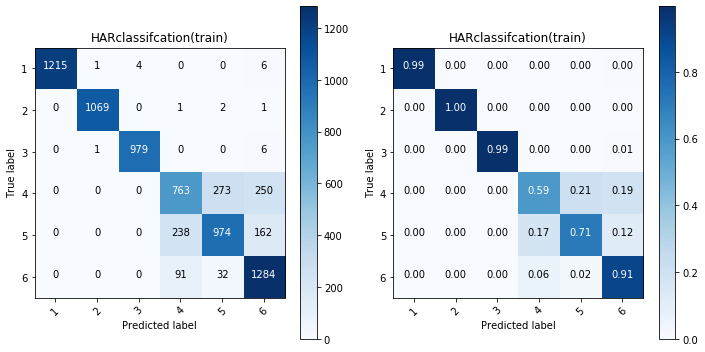

In [32]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False,threshold_weight = np.ones(trainX.shape[0]*128*128).reshape(-1,1,128,128))
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(train)')

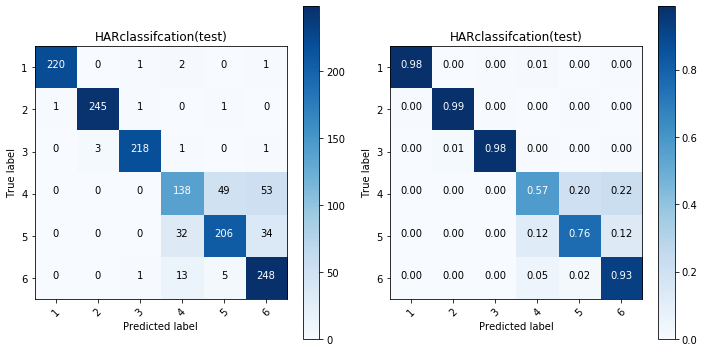

In [33]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0,is_dropout=False,threshold_weight = np.ones(testX.shape[0]*128*128).reshape(-1,1,128,128))
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(test)')

# 6. Trained 된 모델에서 Last Conv output Load하기(MC dropout적용안됨)
기존논문에서 이미지타겟으로 p(A>T)=0.005 인것과 비교하여, 시계열에서는 조금 더 낮은 threshold가 패턴을 보기에 필요함.
acc를 ~이상 떨어지게 하는 threshold

In [34]:
import random

In [36]:
original_acc = MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                          feed_dict={MC_dropout_model.x: trainX,
                                     MC_dropout_model.y: trainY,
                                    MC_dropout_model.keep_prob:1.0,
                                    MC_dropout_model.is_dropout:False,
                                    MC_dropout_model.threshold_weight : np.ones(trainX.shape[0]*128*128).reshape(-1,1,128,128)})

<font color='red'> threshold를 정할 때, 해당 T% 이상인 last convolution activation output을 turnoff 시킬때의 accuracy 변화가 A이상일 때를 기준으로 합니다 </font>

In [40]:
for T in range(995, 885, -5):
    print (T/10.0)

99.5
99.0
98.5
98.0
97.5
97.0
96.5
96.0
95.5
95.0
94.5
94.0
93.5
93.0
92.5
92.0
91.5
91.0
90.5
90.0
89.5
89.0


In [59]:
A=0.1

for T in range(995, 500, -20):
    last_conv_output = MC_dropout_model.get_last_conv_output(data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,:]
    threshold = np.percentile(last_conv_output,T/10.0)
    
    
    last_conv_bool = last_conv_output>threshold
    
    turnoff_acc =MC_dropout_model.sess.run((MC_dropout_model.accuracy), 
                          feed_dict={MC_dropout_model.x: trainX,
                                     MC_dropout_model.y: trainY,
                                    MC_dropout_model.keep_prob:1.0,
                                    MC_dropout_model.is_dropout:False,
                                    MC_dropout_model.threshold_weight :(~last_conv_bool).astype(int).reshape(-1,1,128,128)})
    
    print ("top {}% , threshold: {}------\noriginal acc:{}, turnoff_acc{}".format(100- T/10.0,threshold,original_acc,turnoff_acc))
    if (original_acc - turnoff_acc) > A:
        break

top 0.5% , threshold: 10.984356870651283------
original acc:0.9528926610946655, turnoff_acc0.9513964653015137
top 2.5% , threshold: 7.260601043701172------
original acc:0.9528926610946655, turnoff_acc0.9440968632698059
top 4.5% , threshold: 6.080798149108887------
original acc:0.9528926610946655, turnoff_acc0.9347796440124512
top 6.5% , threshold: 5.373414039611816------
original acc:0.9528926610946655, turnoff_acc0.921858012676239
top 8.5% , threshold: 4.865303900241855------
original acc:0.9528926610946655, turnoff_acc0.9089363217353821
top 10.5% , threshold: 4.468492729663851------
original acc:0.9528926610946655, turnoff_acc0.8956746459007263
top 12.5% , threshold: 4.1405930519104------
original acc:0.9528926610946655, turnoff_acc0.8806220293045044
top 14.5% , threshold: 3.860222339630127------
original acc:0.9528926610946655, turnoff_acc0.8674283623695374
top 16.5% , threshold: 3.6145524978637695------
original acc:0.9528926610946655, turnoff_acc0.8579298257827759
top 18.5% , thre

# 7.Result Visualization
세로축(데이터) , 가로축(마지막 컨볼루션 채널) : 데이터와 별개로 각 채널마다 일관성있게 threshold를 넘은 구간이 존재함

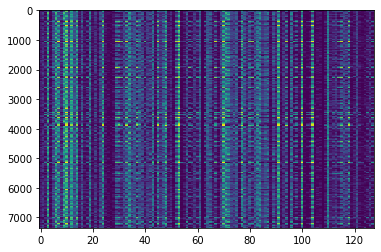

In [60]:
plt.imshow(last_conv_bool.sum(axis=1),aspect ="auto")

In [62]:
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]

## 패턴의 연속성 pattern candidate 추출(전체길이의 10퍼센트 이상이 highlight 된 부분)
## 현재 서버 메모리때문에 trainX 500개까지만 패턴 클러스터링 적용
### 모든 데이터를 위해서는 수정필요

from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

In [63]:
from itertools import groupby
from operator import itemgetter

In [64]:
consecutive_num =trainX.shape[2]//20
consecutive_num

6

In [65]:
import itertools

In [66]:
input_channel = 3
consecutive_pattern=[]
for data_idx,data in enumerate(trainX[:500,:,:,[input_channel]]):
    for output_channel_idx in survived_channel:
        pattern_bool =pd.DataFrame(last_conv_bool[data_idx][:,output_channel_idx])
        pattern_idx = [p for p, x in enumerate(last_conv_bool[data_idx][:,output_channel_idx]) if x]
        if pattern_idx:
            groups = []
            for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
            for g in groups:
                if len(g)>=consecutive_num:
                    for c in range(0,data.shape[2]):
                        consecutive_pattern.append({"data_idx":data_idx, "pattern_idx":g, "pattern":data[0,g,c], "pattern_channel":output_channel_idx})   

In [68]:
pattern = [x['pattern'] for x in consecutive_pattern]

In [69]:
l_pattern=[]
for l in np.unique([len(x) for x in pattern]):
    l_pattern.append(len([x for x in pattern if len(x)==l]))

In [71]:
l_pattern_dict=dict()
for i,l in enumerate(l_pattern):
    l_pattern_dict[str(np.unique([len(x) for x in pattern])[i])]=l

In [72]:
l_pattern_dict

{'6': 16986,
 '7': 12063,
 '8': 8655,
 '9': 6426,
 '10': 4748,
 '11': 3134,
 '12': 2395,
 '13': 1808,
 '14': 1172,
 '15': 926,
 '16': 800,
 '17': 600,
 '18': 594,
 '19': 385,
 '20': 374,
 '21': 299,
 '22': 264,
 '23': 271,
 '24': 171,
 '25': 244,
 '26': 194,
 '27': 165,
 '28': 180,
 '29': 122,
 '30': 136,
 '31': 120,
 '32': 124,
 '33': 72,
 '34': 79,
 '35': 61,
 '36': 52,
 '37': 51,
 '38': 86,
 '39': 67,
 '40': 28,
 '41': 30,
 '42': 40,
 '43': 25,
 '44': 50,
 '45': 89,
 '46': 34,
 '47': 56,
 '48': 29,
 '49': 13,
 '50': 29,
 '51': 9,
 '52': 24,
 '53': 27,
 '54': 23,
 '55': 13,
 '56': 17,
 '57': 13,
 '58': 15,
 '59': 17,
 '60': 13,
 '61': 11,
 '62': 24,
 '63': 28,
 '64': 34,
 '65': 23,
 '66': 8,
 '67': 19,
 '68': 15,
 '69': 10,
 '70': 16,
 '71': 18,
 '72': 11,
 '73': 6,
 '74': 6,
 '75': 17,
 '76': 8,
 '77': 5,
 '78': 11,
 '79': 16,
 '80': 8,
 '81': 13,
 '82': 5,
 '83': 3,
 '84': 2,
 '85': 12,
 '86': 3,
 '87': 4,
 '88': 4,
 '89': 2,
 '90': 6,
 '92': 2,
 '93': 4,
 '94': 1,
 '99': 1,
 '100'

해당 길이 이상의 패턴들을 window slicing 하여 자르는 방법을 이용하실 경우,
밑에 코드를 활성화 하시고, 위에 코드를 주석 처리하시면 됩니다.

input_channel = 3
consecutive_pattern=[]
for data_idx,data in enumerate(trainX[:200,:,:,[input_channel]]):
    for output_channel_idx in survived_channel:
        pattern_bool =pd.DataFrame(last_conv_bool[data_idx][:,output_channel_idx])
        pattern_idx = [p for p, x in enumerate(last_conv_bool[data_idx][:,output_channel_idx]) if x]
        if pattern_idx:
            groups = []
            for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
            for g in groups:
                if len(g)>=consecutive_num:
                    for c in range(0,data.shape[2]):
                        for start_idx in range(0,len(g)-consecutive_num+1,step_size):
                            short_pattern_idx = [g[x] for x in range(start_idx, start_idx+consecutive_num)]
                            consecutive_pattern.append({"data_idx":data_idx, "pattern_idx":short_pattern_idx, "pattern":data[0,short_pattern_idx,c], "pattern_channel":output_channel_idx}) 

In [ ]:
pattern = [x['pattern'] for x in consecutive_pattern]

# clustering

In [ ]:
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

In [ ]:
n_clusters = 5

## clustering with different length scale

#### Global Alignmnet Kernel K Means

In [ ]:
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import GlobalAlignmentKernelKMeans

In [ ]:
#길이를 맞추기위해 nan으로 패딩
X =to_time_series_dataset(pattern)

In [ ]:
gak_km = GlobalAlignmentKernelKMeans(n_clusters=n_clusters)
gak_km_predict = gak_km.fit_predict(X)

class_breakdown(gak_km_predict)

In [ ]:
for n in range(n_clusters):
    idx = [i for i,x in enumerate(gak_km_predict) if x==n]
    vars()["pattern_"+str(n)] = [pattern[i] for i in idx ]

In [ ]:
plt.figure(figsize=(20,5))
for n in range(n_clusters):
    ax= plt.subplot(1,n_clusters,n+1)
    for p in eval("pattern_"+str(n)):
        ax.plot(range(len(p)),p,color = color[n])
plt.tight_layout()

In [ ]:
plt.figure(figsize=(20,5))
for n in range(n_clusters):
    ax= plt.subplot(1,n_clusters,n+1)
    mindexes = [np.argmax(x) for x in eval("pattern_"+str(n))]
    vars()["norm_pattern_"+str(n)] = [(x-min(x)) for x in eval("pattern_"+str(n))]
    for i,p in enumerate(eval("norm_pattern_"+str(n))):
        shifts = max(mindexes) - mindexes[i]
        ax.plot(range(shifts,shifts+len(p)), p,color=color[n],alpha=0.2)

        #plt.plot(range(len(p)), p)
        #break
plt.show()

### find representative shape for each clustering

#### 1. Using U shapelet
ref: Clustering Time Series using Unsupervised-Shapelets

In [ ]:
len(pattern)

In [ ]:
import copy
sLen = range(5,9)
D=copy.deepcopy(pattern)

In [ ]:
S_hat=[]
ts=D[50]
for _ in range(10):
    cnt=0 #count of candidate u-shapelets from ts
    s_hat ={} #set of subsequences, initially empty
    gap = []
    dt =[]
        
    for sl in sLen:#each u-shapelet length
        for i in np.arange(0, len(ts)-sl +1):#each subsequence from ts 
            s_hat[cnt] = ts[i:i+sl] #a subsequence of length sl
            tup = compute_gap(s_hat[cnt],D,6)
            gap.append(tup[0])
            dt.append(tup[1])
            cnt+=1
    if cnt>0:
        index1 = np.argmax(gap)
        S_hat.append(s_hat[index1]) #find maximum gap score
        dis = compute_distance(s_hat[index1],D)#add the u-shapelet with max gap score
        try:
            dA= [dis[i] for i,x in enumerate(dis<dt[index1]) if x==True] #points to the left of dt
        except:
            dA = [dis[i] for i,x in enumerate(dis) if x<dt[0]]

        if len(dA) ==1:
            print("dA length:1")
            break
        else:
            index2 = np.argmax(dis)
            ts = D[index2]
            msdA= np.mean(dA) +np.std(dA)
            D_hat = [i for i,x in enumerate(dis<msdA) if x ==True]
            idx = [x for x in np.arange(0,len(D)) if x not in D_hat]
            new_D=[]
            for d_idx in idx:
                new_D.append(D[d_idx])
            D=new_D

In [ ]:
def znorm(data):
    return (data-min(data))/(max(data)-min(data))

In [ ]:
def euclidean_d(data1,data2):
    return np.linalg.norm(data1-data2)

In [ ]:
def compute_gap(sub, data,cluster_num):
    dis= compute_distance(sub,data)
    dis = np.sort(dis)
    maxGap = 0
    dt = 0
    for l in range(1, len(dis)-1):
        d = (dis[l]+dis[l+1])/2

        dA = dis[dis<d]
        dB = dis[dis>d]
        try:
            r = len(dA)/len(dB)
            if ((1/cluster_num < r) and (1-(1/cluster_num))):
                mA = dA.mean()
                mB = dB.mean()
                sA = dA.std()
                sB = dB.std()
                gap = mB-sB-(mA+sA)
                if gap > maxGap :
                    #print("gap {}".format(gap))
                    maxGap =gap
                    dt =d
        except:
            pass
    return maxGap, dt

In [ ]:
def compute_distance(sub, data):
    dis=[10e3]*len(data)
    sub = znorm(sub)
    for i in range(0,len(data)):
        ts = data[i]

        for j in range(0, len(ts)-len(sub)):
            z = znorm(ts[j:j+len(sub)])
            d = euclidean_d(z,sub)
            dis[i]= min(d,dis[i])/np.sqrt(len(sub))
        #print(dis[i])
    return dis

#### 2. Use dtw measure

In [ ]:
from dtwalign import dtw

In [ ]:
x = norm_pattern_5[60]
y = norm_pattern_5[0]
res = dtw(x,y)

# dtw distance
print("dtw distance: {}".format(res.distance))
print("dtw normalized distance: {}".format(res.normalized_distance))

"""
if you want to calculate only dtw distance (i.e. no need to gain alignment path),
give 'distance_only' argument as True (it makes faster).
"""
#res = dtw(x,y,distance_only=True)

In [ ]:

ax = plt.subplot(2,1,1)
ax.plot(x,color="blue")
ax.plot(y,color="red")
ax.set_ylim(0,1)
# warp both x and y by alignment path
x_path = res.path[:,0]
y_path = res.path[:,1]

ax = plt.subplot(2,1,2)
ax.plot(x[x_path],label="aligned query",color="blue")
ax.plot(y[y_path],label="aligned reference",color="red")
ax.legend()
ax.set_ylim(0,1)

# visualize alignment path with cumsum cost matrix
res.plot_path()

In [ ]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)

In [ ]:
#sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==1]
sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==0]

In [ ]:
plot_idx = 0

for d_idx in sample_data_idx:
######## 특정 샘플의 패턴 리스트 생성  
    # sample_data_idx의 전체 패턴
    specific_data_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if x['data_idx'] ==d_idx]
    specific_pattern_info = [consecutive_pattern[x] for x in specific_data_pattern_idx]
    
    #해당 데이터에 미리 정한 길이만큼의 패턴이 없을 경우 pass
    if len(specific_pattern_info):
        pass
        
    # 총 10개의 plot을 그릴때까지 진행
    if plot_idx ==5:
        break
    
    for p_channel in np.unique([(x['pattern_channel']) for x in specific_pattern_info if (x['data_idx']==d_idx)]):
        plot_idx+=1
        fig, ax= plt.subplots(figsize=(15,3))
        ax.set_xlim([0,int(trainX.shape[2])-1])
        spotlight = last_conv_bool[d_idx,:,p_channel]
        
        # 데이터 자체 그리기
        data = trainX[d_idx,0,:,input_channel]
        ax.plot(data,color='black')
        ax.set_facecolor("grey") # 패턴이 있는 부분만 흰색 spotlight으로 하기 위해 기본 배경을 회색으로 설정
            
        for spotlight_se in [(list(group)) for group in mit.consecutive_groups([i for i,x in enumerate(spotlight) if x==True])]:
            ax.axvspan(spotlight_se[0], spotlight_se[-1], color='white', alpha=1)
                
        for idx,pattern_x, pattern in [(i,x['pattern_idx'],x['pattern']) for i,x in enumerate(specific_pattern_info) if (x['data_idx']==d_idx  and x['pattern_channel']== p_channel)]:
            # 데이터의 해당 패턴 그리기
            pattern_idx = specific_data_pattern_idx[idx]
            color_idx = gak_km_predict[specific_data_pattern_idx.index(pattern_idx)]
            pattern_x = consecutive_pattern[pattern_idx]['pattern_idx']
            #pattern = consecutive_pattern[pattern_idx]['pattern']
            ax.plot(pattern_x, data[pattern_x], color = color[color_idx])
        fig.suptitle("prediction{}, data{}, output_channel{}".format(np.argmax(prediction[d_idx]),d_idx,consecutive_pattern[pattern_idx]['pattern_channel']))
        break

        
    plt.show()

l_pattern_dict :패턴의 길이와 해당 길이의 패턴의 수를 매칭시켜놓은 변수

# clustering for pattern_candidate

1. 패턴의 길이를 fix하고 해당 length의 패턴만을 클러스터링

In [ ]:
pattern_len = 5
specific_len_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if len(x['pattern_idx']) ==pattern_len]

In [ ]:
pattern_candidate =  np.asarray([consecutive_pattern[idx]['pattern'] for idx in specific_len_pattern_idx])
len(pattern_candidate)

## pattern standardization

1. pattern 원본 그대로 사용
2. 평균0, 분산1 형태로 standardization
3. 각 패턴이 0~1 사이로 min,max normalization 

1,2,3 방법 혹은 어떤 방법으로 정규화 할지를 같이 정하면 될것 같습니다.
저는 우선 2번,3번 방법으로 진행해보았습

#1. pattern 원본 그대로 사용
normalized_pattern_candidate =l_pattern_candidate

#2. 평균0, 분산1 형태로 standardization
from sklearn.preprocessing import StandardScaler
normalized_pattern_candidate =StandardScaler().fit_transform(np.asarray(l_pattern_candidate))

In [ ]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
normalized_pattern_candidate =TimeSeriesScalerMeanVariance().fit_transform(pattern_candidate)
normalized_pattern_candidate = normalized_pattern_candidate.squeeze()
normalized_pattern_candidate.shape

In [ ]:
normalized_pattern_candidate = pattern_candidate

#3.각 패턴이 0~1 사이로 min,max normalization
normalized_pattern_candidate = (l_pattern_candidate.T - l_pattern_candidate.min(axis=1))/(l_pattern_candidate.max(axis=1)- l_pattern_candidate.min(axis=1))
normalized_pattern_candidate = normalized_pattern_candidate.T

## spectral clustering, gmm clustering,k-means,SOM

In [ ]:
from sklearn import mixture,cluster
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
#n_cluster : interger
#eigen_solver{None, ‘arpack’, ‘lobpcg’, or ‘amg’}
#affinity: ‘nearest_neighbors’‘rbf’
default_spectral = {'n_clusters':2,
                    'eigen_solver': 'arpack',
                    'affinity': "rbf"}

#covariance_type{‘full’ (default), ‘tied’, ‘diag’, ‘spherical’}
default_gmm = {'n_clusters':2, 'covariance_type': 'full'}
default_kmeans = {'n_clusters':2,'verbose':False,'random_state':0}
default_hac = {'method':'single','metric':'euclidean','cut_off_level':5,'criterion':'maxclust'}

spectral_option = [
    ({'n_clusters': 6})
]

gmm_option = [
    ({'n_clusters': 6})
    
]

kmeans_option = [
    ({'n_clusters': 6})
    
]

hac_option =[
    ({'cut_off_level': 6})
    
]

parameter 조절하며 시각화

In [ ]:
import math
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec

In [ ]:
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]
random.seed(300)
for g_option,k_option in zip(gmm_option,kmeans_option):

    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    k_params = default_kmeans.copy()
    k_params.update(k_option)
    

    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])

    g_pred = gmm.fit_predict(normalized_pattern_candidate)
    k_pred = kmeans.fit_predict(normalized_pattern_candidate)
    
    g_cluster_mean_pattern =[]
    k_cluster_mean_pattern =[]

    fig = plt.figure(figsize=(len(np.unique(g_pred))*3,7))
    axes = fig.subplots(2, g_params['n_clusters'])
    for class_ in range(0,g_params['n_clusters']):
        g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        k_class_idx = [i for i,x in enumerate(k_pred) if x ==class_]

        try:
            axes[0,class_].plot(normalized_pattern_candidate[random.sample(g_class_idx,30)].T, color =color[class_],alpha=0.6)
            axes[1,class_].plot(normalized_pattern_candidate[random.sample(k_class_idx,30)].T, color =color[class_],alpha=0.6)

        except:
            axes[0,class_].plot(normalized_pattern_candidate[g_class_idx].T, color =color[class_],alpha=0.6)
            axes[1,class_].plot(normalized_pattern_candidate[k_class_idx].T, color =color[class_],alpha=0.6)

        g_cluster_mean = normalized_pattern_candidate[g_class_idx].mean(axis=0)
        g_cluster_mean_pattern.append(g_cluster_mean)
        k_cluster_mean = normalized_pattern_candidate[k_class_idx].mean(axis=0)
        k_cluster_mean_pattern.append(k_cluster_mean)
        axes[0,class_].plot(g_cluster_mean, color ='black',alpha=1,linewidth=5)
        axes[1,class_].plot(k_cluster_mean, color ='black',alpha=1,linewidth=5)

    #fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params),y=0.98)
    plt.tight_layout()

In [ ]:
import more_itertools as mit
from sklearn.preprocessing import MinMaxScaler

In [ ]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)

In [ ]:
#sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==1]
sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==0]

In [ ]:
plot_idx = 0

for d_idx in sample_data_idx:
######## 특정 샘플의 패턴 리스트 생성  
    # sample_data_idx의 전체 패턴
    specific_data_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if x['data_idx'] ==d_idx]
    specific_pattern_idx= list(set(specific_data_pattern_idx) & set(specific_len_pattern_idx))
    specific_pattern_info = [consecutive_pattern[x] for x in specific_pattern_idx]
    
    #해당 데이터에 미리 정한 길이만큼의 패턴이 없을 경우 pass
    if len(specific_pattern_info):
        pass
        
    # 총 10개의 plot을 그릴때까지 진행
    if plot_idx ==9:
        break

    
    for p_channel in np.unique([(x['pattern_channel']) for x in specific_pattern_info if (x['data_idx']==d_idx)]):
        plot_idx+=1
        fig, ax= plt.subplots(figsize=(15,3))
        ax.set_xlim([0,int(trainX.shape[2])-1])
        spotlight = last_conv_bool[d_idx,:,p_channel]
        
        # 데이터 자체 그리기
        data = trainX[d_idx,0,:,input_channel]
        ax.plot(data,color='black')
        ax.set_facecolor("grey") # 패턴이 있는 부분만 흰색 spotlight으로 하기 위해 기본 배경을 회색으로 설정
            
        for spotlight_se in [(list(group)) for group in mit.consecutive_groups([i for i,x in enumerate(spotlight) if x==True])]:
            ax.axvspan(spotlight_se[0], spotlight_se[-1], color='white', alpha=1)
                
        for idx,pattern_x, pattern in [(i,x['pattern_idx'],x['pattern']) for i,x in enumerate(specific_pattern_info) if (x['data_idx']==d_idx  and x['pattern_channel']==p_channel)]:
            # 데이터의 해당 패턴 그리기
            pattern_idx = specific_pattern_idx[idx]
            color_idx = g_pred[specific_len_pattern_idx.index(pattern_idx)]
            pattern_x = consecutive_pattern[pattern_idx]['pattern_idx']
            #pattern = consecutive_pattern[pattern_idx]['pattern']
            ax.plot(pattern_x, data[pattern_x], color = color[color_idx])


            # 패턴의 평균값 굵고 투명하게 그리기
            x = g_cluster_mean_pattern[color_idx].reshape(-1,1) #returns a numpy array
            min_max_scaler = MinMaxScaler(feature_range=(data[pattern_x].min(), data[pattern_x].max()))
            x_scaled = min_max_scaler.fit_transform(x)
            ax.plot(pattern_x, x_scaled, color = color[color_idx], alpha=0.4,linewidth=10)
        fig.suptitle("prediction{}, data{}, output_channel{}".format(np.argmax(prediction[d_idx]),d_idx,consecutive_pattern[pattern_idx]['pattern_channel']))
    plt.show()

# Below part is still unclear

f = open('file.txt', 'a+t')
for i,x in enumerate(X):
    for x_ in x:
        f.write(str(x_[0])+",")
    f.write(":"+str(gak_km_predict[i])+"\n")

f.close()      

In [ ]:
X_df = pd.DataFrame(columns=["dim_0"],index=range(len(X)))
for i,x in enumerate(X):
    X_df.iloc[i,0] = x

In [ ]:
Y_df =gak_km_predict.astype('<U1')

In [ ]:
from sktime.transformers.shapelets import ContractedShapeletTransform
# How long (in minutes) to extract shapelets for.
# This is a simple lower-bound initially; once time is up, no further shapelets will be assessed
time_limit_in_mins = 1

# The initial number of shapelet candidates to assess per training series. If all series are visited
# and time remains on the contract then another pass of the data will occur
initial_num_shapelets_per_case = 5

# Whether or not to print on-going information about shapelet extraction. Useful for demo/debugging
verbose = 2

st = ContractedShapeletTransform(
    time_limit_in_mins=time_limit_in_mins,
    num_candidates_to_sample_per_case=initial_num_shapelets_per_case,
    verbose=verbose)
st.fit(X_df, Y_df)

In [ ]:
# for each extracted shapelet (in descending order of quality/information gain)
for s in st.shapelets:

    # summary info about the shapelet
    print(s)

    # plot the series that the shapelet was extracted from
    plt.plot(
        X[s.series_id],
        'gray'
    )

    # overlay the shapelet onto the full series
    plt.plot(
        list(range(s.start_pos,(s.start_pos+s.length))),
        X[s.series_id,s.start_pos:s.start_pos+s.length],
        'r',
        linewidth=3.0
    )
    plt.show()

## hierarchical clustering

In [ ]:
import math
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec

D = hac.linkage(normalized_pattern_candidate[:20], method='single',metric='euclidean')
cut_off_level = 5
#Dendrogram
plt.figure(figsize=(15, 5))
plt.title('Dendrogram of time series clustering',fontsize=25, fontweight='bold')
plt.xlabel('sample index', fontsize=25, fontweight='bold')
plt.ylabel('distance', fontsize=25, fontweight='bold')
hac.dendrogram(D, leaf_rotation=90., leaf_font_size=15., ) # font size for the x axis labels
plt.show()

특정 파라미터에 해당하는 클러스터 시각화

In [ ]:
import matplotlib.patheffects as pe

In [ ]:
random.seed(300)
sample_data_idx = random.sample(range(0,len(normalized_pattern_candidate)),len(normalized_pattern_candidate))
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

In [ ]:
for s_option,g_option,k_option in zip(spectral_option[::-1],gmm_option[::-1],kmeans_option[::-1]):
    s_params = default_spectral.copy()
    s_params.update(s_option)
    
    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    k_params = default_kmeans.copy()
    k_params.update(k_option)
    
    spectral = cluster.SpectralClustering(
        n_clusters=s_params['n_clusters'], 
        eigen_solver=s_params['eigen_solver'],
        affinity=s_params['affinity'])
    
    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])
    
    spectral.fit(normalized_pattern_candidate)
    gmm.fit(normalized_pattern_candidate)
    kmeans.fit(normalized_pattern_candidate)
    
    s_pred = spectral.labels_[sample_data_idx]
    g_pred = gmm.predict(normalized_pattern_candidate[sample_data_idx])
    k_pred = kmeans.fit_predict(normalized_pattern_candidate[sample_data_idx])
    
    num_class = len(list(set(np.unique(s_pred)).union(set(np.unique(g_pred)))))
    fig = plt.figure(figsize=(18,5))
    axes = fig.subplots(3,num_class)    
    
    for class_ in range(0,num_class):
        class_idx = [i for i,x in enumerate(s_pred) if x ==class_]
        try:
            axes[0][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[0][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color = 'black',alpha=1,linewidth=3,
                   path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
        
        class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        try:
            axes[1][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[1][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color ='black',alpha=1,linewidth=3,
                    path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
        class_idx = [i for i,x in enumerate(k_pred) if x ==class_]
        try:
            axes[2][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[2][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color ='black',alpha=1,linewidth=3,
                    path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
    #fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params),y=0.98)
    plt.tight_layout()
    break

# SOM

In [ ]:
import sompy

In [ ]:
som = sompy.SOMFactory.build(normalized_pattern_candidate, mapsize=None, normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=1, verbose=False)  # verbose='debug' will print more, and verbose=None wont print anything

In [ ]:
from sompy.visualization.hitmap import HitMapView
som.cluster(4)
hits  = HitMapView(20,20,"Clustering",text_size=12)
a=hits.show(som)

In [ ]:
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=10)
view2D.show(som, col_sz=4, which_dim="all", desnormalize=True)

In [ ]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(4,4,"Hits Map",text_size=12)
vhts.show(som, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

## represent as feature vector

### 1. wavelet

In [ ]:
import do_wavelet
import matplotlib.gridspec as gridspec
import pywt

In [ ]:
N = normalized_pattern_candidate[3].shape[0]
t0=10
dt=1
time = np.arange(0, N) * dt + t0
signal = normalized_pattern_candidate[3]
 
scales = np.arange(1, 128)

In [ ]:
fig = plt.figure(figsize=(12,6))
spec = gridspec.GridSpec(ncols=6, nrows=6)
top_ax = fig.add_subplot(spec[:2, 0:5])
bottom_left_ax = fig.add_subplot(spec[2:, 0:5])
bottom_right_ax = fig.add_subplot(spec[2:, 5])

plot_signal_plus_average(top_ax, time, signal, average_over = 3)
yticks, ylim = plot_wavelet(bottom_left_ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)

plot_fft_plus_power(bottom_right_ax, time, signal, plot_direction='vertical', yticks=yticks, ylim=ylim)
bottom_right_ax.set_ylabel('Period [years]', fontsize=14)
plt.tight_layout()
plt.show()

### 2. clustering time series using unsupervised shapelets

In [ ]:
D =pattern.copy(deep=True)
sLen = range(6,32)

S_hat={}
ts =D[500]

In [ ]:
len(pattern)

In [ ]:
s_option =spectral_option[-1]
g_option=gmm_option[-1]
s_params = default_spectral.copy()
s_params.update(s_option)

g_params = default_gmm.copy()
g_params.update(g_option)

spectral = cluster.SpectralClustering(
    n_clusters=s_params['n_clusters'], 
    eigen_solver=s_params['eigen_solver'],
    affinity=s_params['affinity'])

gmm =  mixture.GaussianMixture(
    n_components=g_params['n_clusters'], 
    covariance_type=g_params['covariance_type'])

s_pred = spectral.fit_predict(normalized_pattern_candidate)
g_pred = gmm.fit_predict(normalized_pattern_candidate)

s_representative_pattern =[]
g_representative_pattern =[]
for class_ in np.unique(s_pred):

    s_class_idx = [i for i,x in enumerate(s_pred) if x ==class_]
    s_representative_pattern.append(normalized_pattern_candidate[s_class_idx].mean(axis=0))

    g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
    g_representative_pattern.append(normalized_pattern_candidate[g_class_idx].mean(axis=0))


In [ ]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 2, 1,projection='3d')

x = ((g_representative_pattern[0]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
y = ((g_representative_pattern[1]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
z = ((g_representative_pattern[2]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)

ax.scatter(x,y,z, c = g_pred)

ax.set_xlabel('class1')
ax.set_ylabel('class2')
ax.set_zlabel('class3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
#ax.axis('off')

ax2 = fig.add_subplot(1, 2, 2,projection='3d')

x = ((s_representative_pattern[0]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
y = ((s_representative_pattern[1]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
z = ((s_representative_pattern[2]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)

ax2.scatter(x,y,z, c = s_pred)

ax2.set_xlabel('class1')
ax2.set_ylabel('class2')
ax2.set_zlabel('class3')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]
random.seed(300)
for s_option,g_option in zip(spectral_option,gmm_option):
    s_params = default_spectral.copy()
    s_params.update(s_option)
    
    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    spectral = cluster.SpectralClustering(
        n_clusters=s_params['n_clusters'], 
        eigen_solver=s_params['eigen_solver'],
        affinity=s_params['affinity'])
    
    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    s_pred = spectral.fit(normalized_pattern_candidate)
    g_pred = gmm.fit(normalized_pattern_candidate)
    
    sample_data_idx = random.sample(range(0,len(normalized_pattern_candidate)),100)
    
    s_pred = spectral.labels_[sample_data_idx]
    g_pred = gmm.predict(normalized_pattern_candidate[sample_data_idx])
    
    fig = plt.figure(figsize=(15,3))
    for class_ in np.unique(s_pred):
        ax = plt.subplot(1,2,1)
        class_idx = [sample_data_idx[i] for i,x in enumerate(s_pred) if x ==class_]
        ax.plot(normalized_pattern_candidate[class_idx].T, color =color[class_],alpha=0.2)
        ax.plot(normalized_pattern_candidate[class_idx].mean(axis=0), color =color[class_],alpha=1,linewidth=5)

        ax2 = plt.subplot(1,2,2)
        class_idx = [sample_data_idx[i] for i,x in enumerate(g_pred) if x ==class_]
        try:
            #ax2.plot(normalized_pattern_candidate[class_idx].T, color =color[class_],alpha=0.2)
            ax2.plot(normalized_pattern_candidate[class_idx].mean(axis=0), color =color[class_],alpha=1,linewidth=5)
        except:
            continue

    fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params))
    plt.tight_layout()


### plotly visualization을 위해 샘플 데이터 및 패턴 저장

In [ ]:
sample_data_idx=87
sample_output_channel = 79
sample_data = pd.DataFrame(trainX[sample_data_idx].reshape(-1,9))

In [ ]:
sample_pattern_bool =pd.DataFrame(last_conv_bool[sample_data_idx][:,sample_output_channel])
pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx][:,sample_output_channel]) if x]

In [ ]:
last_conv_bool[sample_data_idx][:,sample_output_channel].sum()

In [ ]:
groups = []
for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
    groups.append(list(g))    # Store group iterator as a list

In [ ]:
consecutive_pattern=[]
for g in groups:
    if len(g)>consecutive_num:
        consecutive_pattern.extend(g)
        
consecutive_pattern_bool=[]
for x in range(0,128):
    if x in np.asarray(consecutive_pattern).flatten():
        consecutive_pattern_bool.append(True)
    else:
        consecutive_pattern_bool.append(False)

In [ ]:
sample_consecutive_pattern_bool= pd.DataFrame(consecutive_pattern_bool)

sample_data.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_data.csv')
sample_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_pattern.csv')
sample_consecutive_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_consecutive_pattern.csv')

## 2d visualization

In [ ]:
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

DEFAULT_PLOTLY_COLORS=['rgba(31, 119, 180, {})', 'rgba(255, 127, 14, {})',
                       'rgba(44, 160, 44, {})', 'rgba(214, 39, 40, {})',
                       'rgba(148, 103, 189, {})', 'rgba(140, 86, 75, {})',
                       'rgba(227, 119, 194, {})', 'rgba(127, 127, 127, {})',
                       'rgba(188, 189, 34, {})', 'rgba(23, 190, 207, {})']

normalized_data = (sample_data.values - sample_data.values.min(axis=0))/(sample_data.values.max(axis=0) - sample_data.values.min(axis=0))
for cidx in range(0,sample_data.shape[1]):
    normalized_data[:,cidx] =normalized_data[:,cidx] + cidx 
    
    
fig = make_subplots(
    rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02
)

for cidx in range(sample_data.shape[-1]):
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0]), 
                             y=normalized_data[:,cidx],  
                            line_color="black",
                             line_width=1,
                             showlegend=False,
                             ),
                  row=1, col=1)
    
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0])[consecutive_pattern_bool], 
                            y=normalized_data[consecutive_pattern_bool,cidx],  
#                               fill='toself',
                            line_color='rgba(200, 0, 200, 0.6)',
                            line_width=5,
                            showlegend=False,
                            ),
                   row=1, col=1)
    
fig.update_xaxes(showline=True, linewidth=2, linecolor='black',ticks="inside")
fig.update_yaxes(showline=True, linewidth=2, linecolor='black',
                 ticks="inside",nticks=sample_data.shape[1], tickwidth=2, tickcolor='black', ticklen=10,title_text='Input Channel',
                showgrid=True, gridwidth=1, gridcolor='grey',
                ticktext=["Channel1", "Channel2", "Channel3", "Channel4","Channel5", "Channel6", "Channel7", "Channel8", "Channel9"],
                tickvals=["1", "2", "3", "4", "5", "6","7", "8", "9"],
                range=[0,9])


fig.update_layout(height=600, width=800,plot_bgcolor='rgb(256,256,256)',
                  title_text="Input")

fig.show()

## 3d visualization

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib inline
%matplotlib qt

In [ ]:
random.seed = 10005

class_color= ["cyan","orange","lime","pink","cyan","orange","lime","pink","cyan"]
consecutive_class_color= ["dodgerblue","coral","seagreen","indianred","dodgerblue","coral","seagreen","indianred","dodgerblue"]
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]
sample_channel = random.sample(survived_channel,1)

consecutive_num =trainX.shape[2]//20

for class_i in class_list:
    
    sample_data_idx =random.sample([i for i, e in enumerate(np.argmax(trainY,axis=1)) if e == (class_i-1)],1)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    fig.suptitle("Last Conv ({}) Consecutive ({}) ,Output(class{}) ".format(sample_channel,consecutive_num,class_i-1))
    
    for c in range(0,input_channel):
        data = trainX[sample_data_idx,:,:,c].reshape(-1,1)
        data = (data-data.min())/(data.max()-data.min())
        pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx[0],:,c]) if x]
        #ax = fig.gca(projection='3d')

        ax.plot([c]*len(data),range(0,len(data)), data.flatten())
        # 패턴의 연속성을 찾는 구간
        groups = []
        for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
            groups.append(list(g))    # Store group iterator as a list
        for g in groups:
            if len(g)>consecutive_num:
                ax.scatter([c]*len(g) ,g,data[g],color = consecutive_class_color[c], s =12,alpha=0.7)
                #ax.add_collection3d(plt.fill_between(np.arange(g[0],g[-1]),data[g[0]:g[-1]],0), zs=1, zdir='y')
                #ax[j].text(g[0],0,len(g))
            #else:
                #ax.scatter(g,[c]*len(g), data[g],color = class_color[c],s=12)
                
        ax.set_xticks=[]
        ax.set_yticks=[]
        #ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.8, 0.2, 1]))
    break